# Phase-weighted stack

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/'

## Loading MATLAB files

The data are stored as .MAT files which is the standard data file extension used in MATLAB. There are two ways to load such data, either using the [h5py](https://www.h5py.org/) library, specifically designed to load and save data in HDF5 format, or using the [hdf5storage](https://pythonhosted.org/hdf5storage/) library.

### h5py library

Although this is not a native Python library, it is usually installed in all superclusters and is also already available in Google Colab. Data can be loaded as follows:

In [ ]:
import h5py,numpy
f = h5py.File(data_path+'westSac_180110000058_ch4650_4850.mat','r')
data = numpy.array(f[f['variable/dat'][0,0]])
f.close()
print('Shape:',data.shape)
print('Data array:\n',data)

Shape: (201, 30000)
Data array:
 [[ -38.    2.  -29. ...  -84. -128.  -33.]
 [ -35.   -5.  -23. ...  -81. -154.  -48.]
 [  31.  -61.   56. ... -109.  -34. -289.]
 ...
 [ -12.  132.  -84. ... -274. -226. -232.]
 [ -16.  153. -110. ... -284. -182. -211.]
 [ 110.   68.  -76. ... -130. -120. -137.]]


**Warning:** If the data are not stored within a numpy array, they will no longer be accessible after closing the file (i.e. `f.close()` call.

Below is how a typical 1-minute raw DAS data file looks like. The strain measurements are display in logarithmic scale to emphasize the regions of high seismic activities.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('seaborn')
plt.subplots(figsize=(15,5))
plt.imshow(abs(data),aspect='auto',cmap='inferno',norm=LogNorm())
plt.xlabel('Samples')
plt.ylabel('Channels')
plt.colorbar(pad=0.02).set_label('Strain measurement')
plt.tight_layout()
plt.show()

### hdf5storage library

This library, on the other hand, is not usually installed by default but can be installed using the pip package manager as follows:

In [13]:
%%capture
!pip install hdf5storage

The data can be loaded pretty straightforwadly as follows:

In [ ]:
import hdf5storage
mat = hdf5storage.loadmat(data_path+'westSac_180110000058_ch4650_4850.mat')
data = mat['variable'][0][2][0,0]
print('Shape:',data.shape)
print('Data array:\n',data)

Shape: (30000, 201)
Data array:
 [[ -38.  -35.   31. ...  -12.  -16.  110.]
 [   2.   -5.  -61. ...  132.  153.   68.]
 [ -29.  -23.   56. ...  -84. -110.  -76.]
 ...
 [ -84.  -81. -109. ... -274. -284. -130.]
 [-128. -154.  -34. ... -226. -182. -120.]
 [ -33.  -48. -289. ... -232. -211. -137.]]


As one can noticed, the loaded data array is transposed compared to the array loaded with the h5py library. The `.T` attribute can be used to transpose the array back to the correct version used for cross-correlation.

In [ ]:
data = data.T
print('Shape:',data.shape)
print('Data array:\n',data)

Shape: (201, 30000)
Data array:
 [[ -38.    2.  -29. ...  -84. -128.  -33.]
 [ -35.   -5.  -23. ...  -81. -154.  -48.]
 [  31.  -61.   56. ... -109.  -34. -289.]
 ...
 [ -12.  132.  -84. ... -274. -226. -232.]
 [ -16.  153. -110. ... -284. -182. -211.]
 [ 110.   68.  -76. ... -130. -120. -137.]]


## Installing ArrayUDF

Now that we have HDF5 files containing the DAS data, we can proceed with the cross-correlation but before doing so, we need to install a few packages.

### UNIX libraries

The following packages, which are easily installable using the `apt-get` package manager, will be used to install both the HDF5 library and the ArrayUDF software.

In [2]:
%%capture
!apt-get install libtool
!apt-get install mpich
!apt-get install wget
!apt-get install automake
!apt-get install libfftw3-dev

### HDF5 library

The HDF5 package has to be installed from source to allow parallel processing.

**Warning:** This process can take some time to run.

In [3]:
%%capture
!rm -rf hdf5-1.10.5* ; wget https://s3.amazonaws.com/hdf-wordpress-1/wp-content/uploads/manual/HDF5/HDF5_1_10_5/source/hdf5-1.10.5.tar ; \
tar -xvf hdf5-1.10.5.tar ; rm -rf hdf5-1.10.5.tar ; \
cd hdf5-1.10.5 ; ./configure --enable-parallel --prefix=/usr CC=mpicc ; make install

### FFT algorithm

The ArrayUDF software is the main sofware that will perform the data cross-correlation.

In [5]:
%%capture
!git clone https://bitbucket.org/dbin_sdm/arrayudf-test/src/master/ ArrayUDF ; \
cd ArrayUDF ; autoreconf -i ; ./configure --with-hdf5=/usr CC=mpicc CXX=mpicxx --prefix=/usr ; \
make clean ; make install

The cross-correlation is in fact done using the `das-fft-full.cpp` routine and which can be compiled separately using the corresponding Makefile. The Makefile needs to be slightly edited to reflect the right library name and location.

In [6]:
%%capture
!cd /content/ArrayUDF/examples/das ; \
(cat Makefile | sed -e 's,\/Users\/dbin\/work\/soft,/content,g' > Makefile.new) ; \
(cat Makefile.new | sed -e 's,-mt,,g' > Makefile) ; \
make das-fft-full

## Cross-correlation

In this section, we show how to create cross-correlated data files from the original files and which can be used in the follow-up stacking step.

### Convert data to HDF5 format

Because the cross-correlation through ArrayUDF is done on HDF5 files, the first thing to do is therefore to convert the original `.mat` data files generated by MATLAB to HDF5 files with `.h5` extension. Some of the metadata will also have to be edited during the follow-up stacking procedure but are not needed for the cross-correlation. Therefore, we don't need to copy the metadata to the temporarily created HDF5 file and only the actual data will be transferred.

In [ ]:
import h5py
f = h5py.File('westSac_180110000058_ch4650_4850.h5','w')
f.create_dataset("DataTimeChannel",data=data,dtype="i2")
f.close()

### Executing cross-correlation

The FFT can then be executed by running the `das-fft-full` executable as follows by specifying both input and output filenames as well as the input and output HDF5 key variables where the data will be respectively read then stored. The algorithm follows a detailed procedure described in the [this document](https://bitbucket.org/dbin_sdm/arrayudf-test/src/master/examples/das/doc/preprocess.pdf).

In [ ]:
%%capture
!mpirun --allow-run-as-root -n 1 /content/ArrayUDF/examples/das/das-fft-full -i westSac_180110000058_ch4650_4850.h5 -o 1minXcorr_180110000058_ch4650_4850.h5 -g / -t /DataTimeChannel -x /Xcorr

Below we show the output cross-correlated spectrum generated by ArrayUDF.

In [ ]:
f = h5py.File('1minXcorr_180110000058_ch4650_4850.h5','r')
xcorr_arrayudf = numpy.array(f['Xcorr'])
f.close()
print(xcorr_arrayudf)

[[-2.45732826e-05 -9.27750079e-05 -1.49522486e-04 ... -1.49522486e-04
  -9.27750079e-05 -2.45732826e-05]
 [-1.01813403e-05 -6.41601800e-05 -1.25153456e-04 ... -1.13177324e-04
  -7.21688994e-05 -1.66033969e-05]
 [-2.28469798e-06 -3.37382007e-05 -6.37201738e-05 ...  8.03923540e-05
   6.14318560e-05  3.52616044e-05]
 ...
 [-1.10659785e-05 -7.12606125e-05 -1.30253524e-04 ... -2.67981872e-04
  -1.05591891e-04 -2.33734590e-05]
 [-8.18534954e-06 -6.77844509e-05 -1.43286845e-04 ... -2.34729581e-04
  -9.86772648e-05 -1.61982716e-05]
 [ 1.32705536e-05 -3.10766814e-06 -1.07828921e-04 ... -9.04419903e-06
   6.56174188e-06  8.02446539e-06]]


### Cross-correlation visualization

A first naive plot (that is, just plotting the raw 2D array values) shows a uniform blue background centered at 0 (see colorbar).

In [ ]:
import h5py
with h5py.File("1minXcorr_180110000058_ch4650_4850.h5", "r") as xcorr1:
  print(xcorr1.keys())
  data = xcorr1["Xcorr"][:,:]
  print(type(data),data.shape)
  print(data.min(),data.max())

<KeysViewHDF5 ['Xcorr']>
<class 'numpy.ndarray'> (201, 14999)
-0.050324656 0.27283812


Looking at how data are distributed, the peak is indeed at 0 and the number of matched values per bin decrease rapidly (this is log scaled!).

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2,figsize=(15,5),sharey=True)
ax[0].hist(data.flatten(),log=True,bins=50)
ax[0].set_title('Raw values',fontsize=14)
ax[1].hist(abs(data).flatten(),log=True,bins=50)
ax[1].set_title('Absolute values',fontsize=14)
plt.tight_layout()
plt.show()

You can also print the number of counts for every bins as follows. We'll use the absolute values. The majority of the data are in the lowest bin (closest to 0), this is why the raw values plotted in linear scale will have a uniform background.

In [ ]:
import numpy
counts, edges = numpy.histogram(abs(data).flatten(),bins=50)
for i in range(len(counts)):
  print('{:>9,d} counts between {:>.6e} and {:>.6e}'.format(counts[i],edges[i],edges[i+1]))
  if i==10: break

2,633,539 counts between 8.166587e-10 and 5.456763e-03
  350,857 counts between 5.456763e-03 and 1.091353e-02
   27,327 counts between 1.091353e-02 and 1.637029e-02
    2,156 counts between 1.637029e-02 and 2.182705e-02
      403 counts between 2.182705e-02 and 2.728381e-02
      217 counts between 2.728381e-02 and 3.274057e-02
      124 counts between 3.274057e-02 and 3.819734e-02
       72 counts between 3.819734e-02 and 4.365410e-02
       32 counts between 4.365410e-02 and 4.911086e-02
       11 counts between 4.911086e-02 and 5.456762e-02
        6 counts between 5.456762e-02 and 6.002438e-02


We will now use a logarithmic scale for the color which can be done using the `matplotlib.colors.LogNorm` function in matplotlib.

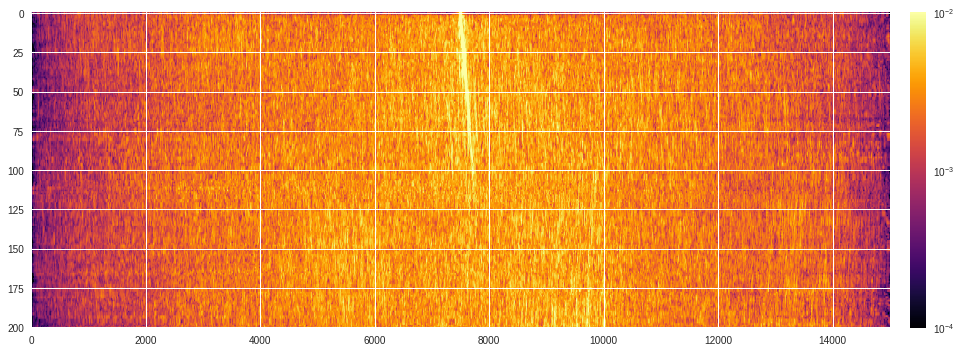

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('seaborn')
plt.subplots(figsize=(15,5))
plt.imshow(abs(data),aspect='auto',cmap='inferno',norm=LogNorm(),vmin=1e-4,vmax=1e-2)
plt.colorbar(pad=0.02)
plt.tight_layout()
plt.show()

### Conversion to MAT format

The output HDF5 cross-correlated spectrum needs to be converted into a readable MATLAB data file format to execute the phase-weighted stack and RMSD calculation algorithms which are both writing in MATLAB. In order to have a readable format, one must ensure that all the metadata are included in the output `.mat` file and edited to reflect the cross-correlation information. We therefore copy the original metadata but update the variables impacted by the cross-correlation.

In [7]:
import copy
import scipy.io as sio
def Xcorr2mat(mat,h5Xcorr):
  # Copy data and metadata into dictionary
  dsi_xcorr = {}
  dsi_xcorr['fh']=mat['variable'][0][0]
  dsi_xcorr['th']=mat['variable'][0][1]
  dsi_xcorr['dat']=mat['variable'][0][2]
  # Open file in read mode
  xfile = h5py.File(h5Xcorr,'r')
  # Load cross-correlated HDF5 data
  xdata = xfile.get('Xcorr')[:,:].T
  # Close HDF5 file
  xfile.close()
  # Extract sample time from file header
  dt = mat['variable'][0][0][0][7][0][0]
  # Define new sample time
  dt_new = 0.008
  # Estimate new relative samping rate 
  R = round(dt_new/dt)
  # Length of resampledcross-correlated data array
  lres = mat['variable'][0][2][0][0].shape[0]/R
  # Maximum duration of new data
  tmax = round((lres-1)*dt_new,6)
  # Update data and file header in dictionary
  dsi_xcorr['dat'][0][0]=numpy.array(xdata[:,:],dtype=numpy.double)
  dsi_xcorr['fh'][0][6]=len(xdata)
  dsi_xcorr['fh'][0][7]=dt_new
  dsi_xcorr['fh'][0][8]=-tmax
  dsi_xcorr['fh'][0][9]=tmax
  dsi_xcorr['fh'][0][10]=[]
  # Save MAT cross-correlated file
  sio.savemat(h5Xcorr.replace('.h5','.mat'), {'dsi_xcorr': dsi_xcorr})

In [ ]:
Xcorr2mat(mat,'1minXcorr_180110000058_ch4650_4850.h5')

## Phase-weighted stack

The phase-weighted stacking is done in MATLAB but can be executed on Google Colab for free using the Octave language.



### Running MATLAB in Octave

Both Octave and its development library must be installed in order to execute the MATLAB codes. Additionally, the signal package has to be installed inside Octave so we can use the butter filter. If trying to install the signal package, it may happen that the error message `signal needs control >= 2.4.5` will display. In order to fix this error, one needs to also install the control control package to update the already current version.

In [3]:
%%capture
!apt install octave liboctave-dev
!octave --eval "pkg install -forge control signal"

In [4]:
%%capture
!tar -zxvf matlab_code.tar.gz
!mkdir xcorr2stack stack_files

### Weighted time-series

We may want to apply some weight to the time series using the machine learning classifier. We have already saved all the probability maps and they can be extracted easily as follows:

In [4]:
%%capture
!tar -zxvf /content/drive/Shared\ drives/ML4DAS/Analysis/Vincent_Dumont/Private/Probability\ Maps/probs.tar.gz

Below is a function that will update the time-series data of each 1-minute file by applying a weights calculated using machine learning:

In [32]:
import numpy
def ts_weighting(fname,data):
  probs = numpy.loadtxt('/content/probmaps/%s.txt'%fname)
  probs = numpy.array([[[prob]*(data.shape[1]//len(probs)) for prob in probs] for i in range(data.shape[0])]).reshape(data.shape)
  return data * probs

### Aggregated stacking

The function below is designed to execute both ArrayUDF and the MATLAB-written phase-weighted stack algorithm on a Google Colab notebook, assuming ArrayUDF and Octve to be installed.

In [33]:
import hdf5storage,re,h5py,os
def phase_weight_stack(fpath,idx,weight=False):
  fname = re.split('[/.]',fpath)[-2]
  xcorr = fname.replace('westSac','1minXcorr')
  # Copy raw data to temporary HDF5 file
  mat = hdf5storage.loadmat(fpath)
  data = mat['variable'][0][2][0,0].T
  if weight: data = ts_weighting(fname,data)
  f = h5py.File(fname+'.h5','w')
  f.create_dataset("DataTimeChannel",data=data,dtype="i2")
  f.close()
  # Execute cross-correlation using ArrayUDF
  os.system('mpirun --allow-run-as-root -n 1 /content/ArrayUDF/examples/das/das-fft-full -i %s.h5 -o %s.h5 -g / -t /DataTimeChannel -x /Xcorr'%(fname,xcorr))
  # Convert cross-correlated data from h5 to mat format
  Xcorr2mat(mat,xcorr+'.h5')
  # Move mat file to xcorr2stack folder
  os.system('mv *.mat xcorr2stack && rm *.h5')
  # Execute stacking
  !octave -W /content/SCRIPT_run_Stacking.m > out && rm out
  # Rename stacking stage results
  os.system('mv stack_files/Dsi_mstack.mat stack_files/Dsi_mstack_nstack%s.mat'%idx)
  os.system('mv stack_files/Dsi_pwstack.mat stack_files/Dsi_pwstack_nstack%s.mat'%idx)

We can then execute the above script within a loop over several continuous 1-minute data files.

In [34]:
import glob,os
threshold = 115
file_list = sorted(glob.glob(data_path+'*'))[:threshold]
for i,fpath in enumerate(file_list):
  idx = ('{:>0%i}'%len(str(threshold))).format(i+1)
  print(idx,'-',fpath)
  phase_weight_stack(fpath,idx,weight=True)
  if os.path.exists('stop'): break

001 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000031_ch4650_4850.mat
002 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000131_ch4650_4850.mat
003 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000231_ch4650_4850.mat
004 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000331_ch4650_4850.mat
005 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000431_ch4650_4850.mat
006 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000531_ch4650_4850.mat
007 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000631_ch4650_4850.mat
008 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000731_ch4650_4850.mat
009 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_4850/westSac_180103000831_ch4650_4850.mat
010 - /content/drive/Shared drives/ML4DAS/RawData/1min_ch4650_48

### Sorted by probability

In [10]:
%%capture
!tar -zxvf /content/drive/Shared\ drives/ML4DAS/RawData/1min_probmaps_200x200.tar.gz
!tar -zxvf /content/drive/Shared\ drives/ML4DAS/RawData/115min_Stacking/non-weighted_xcorr2stack.tar.gz
!mv xcorr2stack xcorr_files && mkdir -p xcorr2stack stack_files

In [ ]:
import numpy,glob,os
threshold = 115
xcorr = sorted(glob.glob('xcorr_files/*.mat'))[:threshold]
probs = sorted(glob.glob('probmaps/westSac*.txt'))[:threshold]
probs = [numpy.average(numpy.loadtxt(fname)) for fname in probs]
for i,n in enumerate(numpy.argsort(probs)):
  idx = ('{:>0%i}'%len(str(threshold))).format(i+1)
  print(idx,'-',xcorr[n])
  os.system('mv %s xcorr2stack'%xcorr[n])
  !octave -W /content/SCRIPT_run_Stacking.m > out && rm out
  os.system('mv stack_files/Dsi_mstack.mat stack_files/Dsi_mstack_nstack%s.mat'%idx)
  os.system('mv stack_files/Dsi_pwstack.mat stack_files/Dsi_pwstack_nstack%s.mat'%idx)
  if os.path.exists('stop'): break

001 - xcorr_files/1minXcorr_180103000031_ch4650_4850.mat
002 - xcorr_files/1minXcorr_180103014631_ch4650_4850.mat
003 - xcorr_files/1minXcorr_180103002031_ch4650_4850.mat
004 - xcorr_files/1minXcorr_180103001631_ch4650_4850.mat
005 - xcorr_files/1minXcorr_180103003531_ch4650_4850.mat
006 - xcorr_files/1minXcorr_180103014131_ch4650_4850.mat
007 - xcorr_files/1minXcorr_180103004231_ch4650_4850.mat


### Stacked spectra visualization

In [ ]:
import hdf5storage
import matplotlib.pyplot as plt
for i in range(2,115):
  mat = hdf5storage.loadmat('/content/stack_files/Dsi_pwstack_nstack%03i.mat'%i)
  data = mat['Dsi_pwstack'][0][0][3][0][0].T[::-1]
  plt.style.use('seaborn')
  plt.figure(figsize=(12,4),dpi=80)
  plt.imshow(data,extent=[-59,59,0,data.shape[0]],aspect='auto',cmap='rainbow',vmin=0,vmax=1)
  plt.colorbar(pad=0.01)
  plt.tight_layout()
  plt.title('nstack: {:>3}'.format(i))
  plt.savefig('image%03i'%i)
  plt.close()

In [ ]:
%%capture
!ffmpeg -i image%03d.png video.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""<video width=100%% controls loop><source src="%s" type="video/mp4"></video>""" % data_url)

## RMSD calculation

The root-mean-square deviation can be calculated for each aggregated stack to investigate the stability of the stacked cross-correlated data and identify when temporal stability and high signal-to-noise is reached.

In [9]:
!rm stack_files/*

In [5]:
%%capture
!octave -W /content/SCRIPT_calculate_rmsd_stack.m

In [7]:
!cp /content/drive/Shared\ drives/ML4DAS/RawData/115min_Stacking/weighted_spec_rmsd.txt .
!cp /content/drive/Shared\ drives/ML4DAS/RawData/115min_Stacking/weighted_spec_rmsd_sorted.txt .
!cp /content/drive/Shared\ drives/ML4DAS/RawData/115min_Stacking/non-weighted_spec_rmsd.txt .
!cp /content/drive/Shared\ drives/ML4DAS/RawData/115min_Stacking/non-weighted_spec_rmsd_sorted.txt .

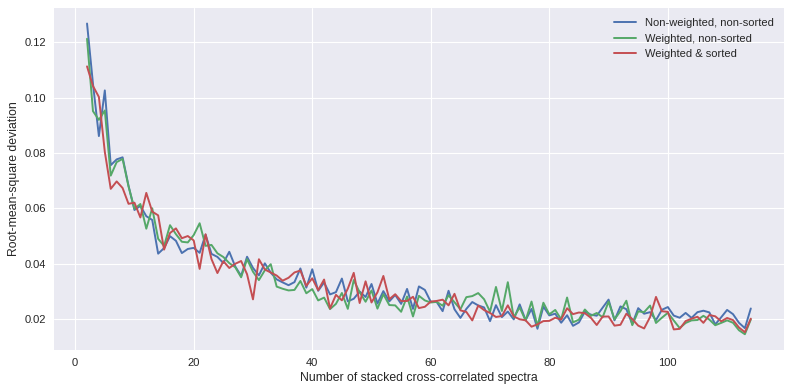

In [8]:
import numpy
import matplotlib.pyplot as plt
y1 = numpy.loadtxt('non-weighted_spec_rmsd.txt')[1:]
y2 = numpy.loadtxt('weighted_spec_rmsd.txt')[1:-1]
y3 = numpy.loadtxt('weighted_spec_rmsd_sorted.txt')[1:-1]
x = numpy.arange(len(y1))+2
plt.style.use('seaborn')
plt.subplots(figsize=(10,5),dpi=80)
plt.plot(x,y1,label='Non-weighted, non-sorted')
plt.plot(x,y2,label='Weighted, non-sorted')
plt.plot(x,y3,label='Weighted & sorted')
plt.xlabel('Number of stacked cross-correlated spectra')
plt.ylabel('Root-mean-square deviation')
plt.legend(loc='best')
plt.tight_layout()
plt.show()